In [2]:
# data cleaning
import numpy as np
import pandas as pd

# feature engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans

# model
from xgboost import XGBRegressor

# error score
from sklearn.model_selection import cross_val_score

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load data
data = pd.read_csv(r'train.csv', index_col='Id')
data_test = pd.read_csv(r'test.csv', index_col='Id')

In [4]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Missing Values - Train Data

In [6]:
# missing data
total_missing = data.isnull().sum().sort_values(ascending=False)
percent_missing = (data.isnull().sum() / data.isnull().count())*100
missing_data = pd.concat([total_missing, percent_missing], axis=1,
                         keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


#### Droping data columns with 15% missing value

In [7]:
data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 
                  'Fence', 'FireplaceQu', 'LotFrontage'], 
                 axis=1)
data.shape

(1460, 74)

We going to write a function To find missing values in each columns

In [8]:
# missing values - function
def missing_values(data, n):
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (data.isnull().sum() / data.isnull().count())*100
    missing_data = pd.concat([total_missing, percent_missing], axis=1,
                            keys=['Total', 'Percent'])
    return missing_data.head(n)

In [9]:
# missing data
missing_values(data, 14)

,Total,Percent
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtFinType1,37,2.534247


#### Column - GarageType
NA - No Garage

so we can replace NA with No Garage

In [10]:
data.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [11]:
data.GarageType = data.GarageType.fillna('No Garage')
missing_values(data, 13)

,Total,Percent
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrArea,8,0.547945


#### Column - GarageYrBlt

In [12]:
data.GarageYrBlt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [13]:
# finding index of missing values
idx = data[data['GarageYrBlt'].isnull()].index.tolist()
data.iloc[idx].head(6)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
41,20,RL,8658,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,12,2006,WD,Abnorml,160000
50,20,RL,7742,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,0,0,0,0,0,1,2007,WD,Normal,127000
80,50,RM,10440,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,...,128,0,0,0,0,5,2009,WD,Normal,110000
90,20,RL,8070,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,8,2007,WD,Normal,123600
91,20,RL,7200,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,7,2006,WD,Normal,109900
101,20,RL,10603,Pave,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,205000


Filling missing values in GarageYrBlt column

In [14]:
data.GarageYrBlt = data.GarageYrBlt.fillna(method='bfill',
                                           axis=0)
missing_values(data, 12)

,Total,Percent
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945


#### Column - GarageFinish
NA - No Garage

so we can replace NA with No Garage

In [15]:
data.GarageFinish.unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [16]:
data.GarageFinish = data.GarageFinish.fillna('No Garage')
missing_values(data, 11)

,Total,Percent
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtCond,37,2.534247
BsmtQual,37,2.534247
BsmtFinType1,37,2.534247
MasVnrArea,8,0.547945
MasVnrType,8,0.547945
Electrical,1,0.068493


#### Column - GarageQual
NA - No Garage

so we can replace NA with No Garage

In [17]:
data.GarageQual.unique()

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

In [18]:
data.GarageQual = data.GarageQual.fillna('No Garage')
missing_values(data, 10)

,Total,Percent
GarageCond,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtQual,37,2.534247
BsmtCond,37,2.534247
BsmtFinType1,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
Functional,0,0.000000


#### Column - GarageCond
NA - No Garage

so we can replace NA with No Garage

In [19]:
data.GarageCond = data.GarageCond.fillna('No Garage')
missing_values(data, 9)

,Total,Percent
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
Functional,0,0.000000


#### Column - BsmtFinType2
NA - No Basement

so we can replace NA with No Basement

In [20]:
data.BsmtFinType2.unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [21]:
data.BsmtFinType2 = data.BsmtFinType2.fillna('No Basement')
missing_values(data, 8)

,Total,Percent
BsmtExposure,38,2.602740
BsmtFinType1,37,2.534247
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
HalfBath,0,0.000000


#### Column - BsmtExposure
NA - No Basement

so we can replace NA with No Basement

In [22]:
data.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [23]:
data.BsmtExposure = data.BsmtExposure.fillna('No Basement')
missing_values(data, 7)

,Total,Percent
BsmtFinType1,37,2.534247
BsmtCond,37,2.534247
BsmtQual,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
BsmtHalfBath,0,0.000000


#### Column - BsmtFinType1
NA - No Basement

so we can replace NA with No Basement

In [24]:
data.BsmtFinType1.unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [25]:
data.BsmtFinType1 = data.BsmtFinType1.fillna('No Basement')
missing_values(data, 6)

,Total,Percent
BsmtQual,37,2.534247
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
GarageType,0,0.000000


#### Column - BsmtQual
NA - No Basement

so we can replace NA with No Basement

In [26]:
data.BsmtQual.unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [27]:
data.BsmtQual = data.BsmtQual.fillna('No Basement')
missing_values(data, 5)

,Total,Percent
BsmtCond,37,2.534247
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
MSSubClass,0,0.000000


#### Column - BsmtCond
NA - No Basement

So we can replace NA with No Basement

In [29]:
data.BsmtCond.unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [30]:
data.BsmtCond = data.BsmtCond.fillna('No Basement')
missing_values(data, 4)

,Total,Percent
MasVnrType,8,0.547945
MasVnrArea,8,0.547945
Electrical,1,0.068493
BedroomAbvGr,0,0.000000


#### Column - MasVnrType
Cinder Block **NOT** found in the data set

So  we assuming that missing values are Cinder Blockes

In [31]:
data.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [32]:
data.MasVnrType = data.MasVnrType.fillna('CBlock')
missing_values(data, 3)

,Total,Percent
MasVnrArea,8,0.547945
Electrical,1,0.068493
GarageYrBlt,0,0.000000


#### Column - MasVnrArea
missing values filling by using **back-fill** method

In [33]:
data.MasVnrArea.unique()

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

In [34]:
data.MasVnrArea = data.MasVnrArea.fillna(method='bfill',
                                         axis=0)
missing_values(data, 2)

,Total,Percent
Electrical,1,0.068493
MSSubClass,0,0.000000


#### Column - Electrical
Missing value filling by using **back-fill** method

In [35]:
data.Electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [36]:
data.Electrical = data.Electrical.fillna(method='bfill',
                                        axis=0)
missing_values(data, 2)

,Total,Percent
MSSubClass,0,0.0
GarageYrBlt,0,0.0


### Missing Values - Test Data

In [37]:
missing_values(data_test, 34)

,Total,Percent
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageQual,78,5.346127
GarageCond,78,5.346127


##### Droping columns with >15% missing values

In [38]:
data_test = data_test.drop(['PoolQC', 'MiscFeature', 'Alley', 
                  'Fence', 'FireplaceQu', 'LotFrontage'], 
                 axis=1)
data.shape

(1460, 74)

In [39]:
# missing data
missing_values(data_test, 28)

,Total,Percent
GarageQual,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageCond,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684


#### Column - GarageQual
NA - No Garage

So we can replace NA with No Garage

In [40]:
data_test.GarageQual.unique()

array(['TA', nan, 'Fa', 'Gd', 'Po'], dtype=object)

In [41]:
data_test.GarageQual = data_test.GarageQual.fillna('No Garage')
missing_values(data_test, 27)

,Total,Percent
GarageCond,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642


#### Column - GarageCond
NA - No Garage

So we can replace NA with No Garage

In [42]:
data_test.GarageCond.unique()

array(['TA', nan, 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

In [43]:
data_test.GarageCond = data_test.GarageCond.fillna('No Garage')
missing_values(data_test, 26)

,Total,Percent
GarageFinish,78,5.346127
GarageYrBlt,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101


#### Column - GarageFinish
NA - No Garage

So we can replace NA with No Garage

In [44]:
data_test.GarageFinish.unique()

array(['Unf', 'Fin', 'RFn', nan], dtype=object)

In [45]:
data_test.GarageFinish = data_test.GarageFinish.fillna('No Garage')
missing_values(data_test, 25)

,Total,Percent
GarageYrBlt,78,5.346127
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160


#### Column - GarageYrBlt
Replace missing values by **back-fill** method

In [46]:
data_test.GarageYrBlt.unique()

array([1961., 1958., 1997., 1998., 1992., 1993., 1990., 1970., 1999.,
       1971., 1975., 2009., 2005., 2003., 2002., 2006., 2004., 1920.,
       1974., 2000., 2010., 1967., 1978., 1966., 1964.,   nan, 1994.,
       1949., 1959., 1956., 1952., 1955., 1989., 1950., 1960., 1963.,
       1900., 1957., 1938., 1948., 1962., 1928., 1930., 1926., 1939.,
       1973., 1942., 1979., 1923., 1915., 1917., 1940., 1910., 1969.,
       1968., 1977., 1945., 1987., 1947., 1954., 1941., 1951., 1896.,
       1976., 2008., 2007., 1965., 2001., 1972., 1984., 1985., 1996.,
       1995., 1980., 1986., 1981., 1982., 1991., 1988., 1953., 1924.,
       1927., 1946., 1934., 1983., 1916., 1918., 1937., 1932., 1935.,
       1925., 1921., 1895., 1922., 2207., 1936., 1943., 1919.])

In [47]:
data_test.GarageYrBlt = data_test.GarageYrBlt.fillna(method='bfill', axis=0)
missing_values(data_test, 24)

,Total,Percent
GarageType,76,5.209047
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080


#### Column - GarageType
NA - No Garage

So we can replace NA with No Garage

In [48]:
data_test.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', nan, 'Basment', '2Types', 'CarPort'],
      dtype=object)

In [49]:
data_test.GarageType = data_test.GarageType.fillna('No Garage')
missing_values(data_test, 23)

,Total,Percent
BsmtCond,45,3.084304
BsmtExposure,44,3.015764
BsmtQual,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
Functional,2,0.137080


#### Column - BsmtCond
NA - No Basement

So we can replace NA with No Basement

In [50]:
data_test.BsmtCond.unique()

array(['TA', 'Po', 'Fa', 'Gd', nan], dtype=object)

In [51]:
data_test.BsmtCond = data_test.BsmtCond.fillna('No Basement')
missing_values(data_test, 22)

,Total,Percent
BsmtQual,44,3.015764
BsmtExposure,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080


#### Column - BsmtQual
NA - No Basement

So we can replace NA with No Basement

In [52]:
data_test.BsmtQual.unique()

array(['TA', 'Gd', 'Ex', 'Fa', nan], dtype=object)

In [53]:
data_test.BsmtQual = data_test.BsmtQual.fillna('No Basement')
missing_values(data_test, 21)

,Total,Percent
BsmtExposure,44,3.015764
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtFullBath,2,0.137080
Utilities,2,0.137080
BsmtHalfBath,2,0.137080


#### Column - BsmtExposure
NA - No Basement

So we can replace NA with No Basement

In [54]:
data_test.BsmtExposure.unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [55]:
data_test.BsmtExposure = data_test.BsmtExposure.fillna('No Basement')
missing_values(data_test, 20)

,Total,Percent
BsmtFinType2,42,2.878684
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Functional,2,0.137080
GarageCars,1,0.068540


#### Column - BsmtFinType2
NA - No Basement

So we can replace NA with No Basement

In [56]:
data_test.BsmtFinType2.unique()

array(['LwQ', 'Unf', 'Rec', 'BLQ', 'GLQ', 'ALQ', nan], dtype=object)

In [57]:
data_test.BsmtFinType2 = data_test.BsmtFinType2.fillna('No Basement')
missing_values(data_test, 19)

,Total,Percent
BsmtFinType1,42,2.878684
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Functional,2,0.137080
Utilities,2,0.137080
BsmtFinSF1,1,0.068540
Exterior1st,1,0.068540


#### Column - BsmtFinType1
NA - No Basement

So we can replace NA with No Basement

In [58]:
data_test.BsmtFinType1.unique()

array(['Rec', 'ALQ', 'GLQ', 'Unf', 'BLQ', 'LwQ', nan], dtype=object)

In [59]:
data_test.BsmtFinType1 = data_test.BsmtFinType1.fillna('No Basement')
missing_values(data_test, 18)

,Total,Percent
MasVnrType,16,1.096642
MasVnrArea,15,1.028101
MSZoning,4,0.274160
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Functional,2,0.137080
KitchenQual,1,0.068540
Exterior2nd,1,0.068540
GarageCars,1,0.068540


#### Column - MasVnrType
Cinder Block NOT found in the data set

So we assuming that missing values are Cinder Blockes

In [60]:
data_test.MasVnrType.unique()

array(['None', 'BrkFace', 'Stone', 'BrkCmn', nan], dtype=object)

In [61]:
data_test.MasVnrType = data_test.MasVnrType.fillna('CBlock')
missing_values(data_test, 17)

,Total,Percent
MasVnrArea,15,1.028101
MSZoning,4,0.274160
Functional,2,0.137080
BsmtFullBath,2,0.137080
BsmtHalfBath,2,0.137080
Utilities,2,0.137080
Exterior1st,1,0.068540
BsmtFinSF2,1,0.068540
KitchenQual,1,0.068540
BsmtFinSF1,1,0.068540


#### Column - MasVnrArea
Filling missing values with **back-fill** method

In [62]:
data_test.MasVnrArea.unique()

array([0.000e+00, 1.080e+02, 2.000e+01, 5.040e+02, 4.920e+02, 1.620e+02,
       2.560e+02, 6.150e+02, 2.400e+02, 1.095e+03, 2.320e+02, 1.780e+02,
       1.400e+01, 1.140e+02, 2.260e+02, 1.220e+02, 2.500e+02, 1.800e+02,
       1.200e+02, 2.160e+02, 1.159e+03, 1.720e+02, 2.680e+02, 1.440e+02,
       2.650e+02, 3.400e+02, 5.060e+02, 1.500e+02, 9.100e+01, 4.320e+02,
       2.180e+02, 7.710e+02, 3.000e+02, 9.000e+01, 7.200e+01, 4.700e+01,
       2.880e+02, 9.600e+01, 1.770e+02, 8.500e+01, 8.000e+01, 3.200e+02,
       1.700e+02, 2.030e+02, 3.710e+02, 4.300e+02, 4.400e+01, 1.860e+02,
       6.000e+01, 4.400e+02, 1.880e+02, 3.200e+01, 4.500e+01, 1.570e+02,
       1.010e+02, 2.290e+02, 1.610e+02, 1.960e+02, 4.250e+02, 1.650e+02,
       7.260e+02, 4.500e+02, 4.720e+02, 3.020e+02, 2.380e+02, 2.840e+02,
       2.850e+02, 4.180e+02, 7.240e+02, 3.830e+02, 1.350e+02, 1.760e+02,
       7.300e+02, 4.700e+02, 3.080e+02, 5.000e+02, 2.700e+02, 1.630e+02,
       1.600e+01, 2.000e+02,       nan, 2.100e+02, 

In [63]:
data_test.MasVnrArea = data_test.MasVnrArea.fillna(method='bfill',
                                                   axis=0)
missing_values(data_test, 16)

,Total,Percent
MSZoning,4,0.27416
BsmtHalfBath,2,0.13708
Functional,2,0.13708
BsmtFullBath,2,0.13708
Utilities,2,0.13708
Exterior1st,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854


#### Column - MSZoning
Filling missing values with **back-fill** method

In [64]:
data_test.MSZoning.unique()

array(['RH', 'RL', 'RM', 'FV', 'C (all)', nan], dtype=object)

In [65]:
data_test.MSZoning = data_test.MSZoning.fillna(method='bfill',
                                              axis=0)
missing_values(data_test, 15)

,Total,Percent
Functional,2,0.13708
BsmtFullBath,2,0.13708
Utilities,2,0.13708
BsmtHalfBath,2,0.13708
Exterior1st,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854


#### Column - Functional
Salvage only missing from list, so lets assuming that missing values is Salvage only

In [66]:
data_test.Functional.unique()

array(['Typ', 'Min2', 'Min1', 'Mod', 'Maj1', 'Sev', 'Maj2', nan],
      dtype=object)

In [67]:
data_test.Functional = data_test.Functional.fillna('Sal')
missing_values(data_test, 14)

,Total,Percent
BsmtFullBath,2,0.13708
Utilities,2,0.13708
BsmtHalfBath,2,0.13708
Exterior1st,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
BsmtUnfSF,1,0.06854


#### Column - BsmtFullBath
Missing values filling by using **back-fill** method

In [68]:
data_test.BsmtFullBath.unique()

array([ 0.,  1.,  2.,  3., nan])

In [69]:
data_test.BsmtFullBath = data_test.BsmtFullBath.fillna(method='bfill',
                                                      axis=0)
missing_values(data_test, 13)

,Total,Percent
BsmtHalfBath,2,0.13708
Utilities,2,0.13708
Exterior1st,1,0.06854
BsmtUnfSF,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
TotalBsmtSF,1,0.06854


#### Column - BsmtHalfBath
Missing values filling by using **back-fill** method

In [70]:
data_test.BsmtHalfBath.unique()

array([ 0.,  1., nan,  2.])

In [71]:
data_test.BsmtHalfBath = data_test.BsmtHalfBath.fillna(method='bfill',
                                                      axis=0)
missing_values(data_test, 12)

,Total,Percent
Utilities,2,0.13708
Exterior1st,1,0.06854
BsmtUnfSF,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
TotalBsmtSF,1,0.06854
SaleType,1,0.06854


#### Column - Utilities
Missing values filling by using **back-fill** method

In [72]:
data_test.Utilities.unique()

array(['AllPub', nan], dtype=object)

In [73]:
data_test.Utilities = data_test.Utilities.fillna(method='bfill',
                                                axis=0)
missing_values(data_test, 11)

,Total,Percent
Exterior2nd,1,0.06854
SaleType,1,0.06854
Exterior1st,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
KitchenQual,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854


#### Column - Exterior2nd
Other is **NOT** in the list, so we assuming that Other is the missing value

In [74]:
data_test.Exterior2nd.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'Brk Cmn',
       'CmentBd', 'ImStucc', 'Wd Shng', 'AsbShng', 'Stucco', 'CBlock',
       'BrkFace', 'AsphShn', nan, 'Stone'], dtype=object)

In [75]:
data.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [76]:
data_test.Exterior2nd = data_test.Exterior2nd.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 10)

,Total,Percent
Exterior1st,1,0.06854
SaleType,1,0.06854
KitchenQual,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
HalfBath,0,0.00000


#### Column - Exterior1st
Missing value filling by using **back-fill** method

In [77]:
data_test.Exterior1st.unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
       'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
       nan, 'CBlock'], dtype=object)

In [78]:
data_test.Exterior1st = data_test.Exterior1st.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 9)

,Total,Percent
SaleType,1,0.06854
KitchenQual,1,0.06854
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - SaleType
Missing value filling by using **back-fill** method

In [79]:
data_test.SaleType.unique()

array(['WD', 'COD', 'New', 'ConLD', 'Oth', 'Con', 'ConLw', 'ConLI', 'CWD',
       nan], dtype=object)

In [80]:
data_test.SaleType = data_test.SaleType.fillna(method='bfill',
                                              axis=0)
missing_values(data_test, 8)

,Total,Percent
TotalBsmtSF,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
KitchenQual,1,0.06854
BsmtFinSF1,1,0.06854
GarageCars,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - TotalBsmtSF
Missing values filling by using **back-fill** method

In [82]:
data_test.TotalBsmtSF.unique()

array([ 882., 1329.,  928.,  926., 1280.,  763., 1168.,  789., 1300.,
       1405.,  483.,  525.,  855.,  836., 1590., 1544., 1698., 1822.,
       2846., 1671., 1370., 1324., 1145.,  384.,  847., 1629., 1595.,
       1218., 1468.,  831.,  816., 1208., 1231., 1390., 1488.,  840.,
        600.,  756.,  530., 1642.,  975., 1492., 1829., 1224.,  715.,
       1232., 1209., 1510.,  533., 1728., 1140.,  782., 1080., 1604.,
       1480., 1143., 1206., 1244.,  832.,  864.,  972.,  988.,  576.,
       1175., 1395.,  709.,  936., 1347.,  827., 1027., 1008.,  678.,
        930.,  346.,  738., 1108.,  765.,  608.,  572.,  835.,  780.,
        528., 1124.,  888.,  662., 1422.,  689., 1212.,  707.,  856.,
       1832., 1319.,  720., 1420.,  660., 1117.,  663., 1172., 1508.,
       1250., 1433.,  946., 1222.,  676.,  870.,  878., 1026.,  876.,
       1978., 1040.,  848.,    0.,  381., 1196.,  744.,  960., 1107.,
        894., 1528., 1032.,  423.,  982., 1191.,  480.,  629., 1594.,
       1049., 1243.,

In [83]:
data_test.TotalBsmtSF = data_test.TotalBsmtSF.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 7)

,Total,Percent
KitchenQual,1,0.06854
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
GarageCars,1,0.06854
BsmtFinSF1,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - KitchenQual
Missing value filling by using **back-fill** method

In [84]:
data_test.KitchenQual.unique()

array(['TA', 'Gd', 'Ex', 'Fa', nan], dtype=object)

In [85]:
data_test.KitchenQual = data_test.KitchenQual.fillna(method='bfill',
                                                    axis=0)
missing_values(data_test, 6)

,Total,Percent
BsmtUnfSF,1,0.06854
BsmtFinSF2,1,0.06854
GarageCars,1,0.06854
BsmtFinSF1,1,0.06854
GarageArea,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtUnfSF
Missing values filling by using **back-fill** method

In [86]:
data_test.BsmtUnfSF.unique()

array([ 270.,  406.,  137.,  324., 1017.,  763.,  233.,  789.,  663.,
          0.,  354.,  327.,  225.,  341.,  836., 1590., 1544., 1588.,
       1794., 1473., 1093., 1346., 1324., 1129.,   58.,  847., 1629.,
       1595., 1218.,   54.,  831.,  816.,  223.,  261.,  190.,  840.,
        320.,  224.,  290.,  286.,  610.,  491.,  659., 1323.,  143.,
        386.,  534.,  150.,  500.,  533.,  228.,  470.,  482.,  136.,
       1604.,  292.,  125.,  510.,  832.,  525.,  456.,  576.,  161.,
        237.,  415.,  661.,  357.,  827.,  247.,  678.,  930.,  346.,
        455.,  200.,  634.,  577.,  144.,  308.,  316.,  480.,  252.,
        164.,  888.,  780.,  662.,  656.,  689.,  186.,  232.,  120.,
       1128.,   89.,  328.,  660.,  153.,  172.,  564.,  218.,  162.,
       1250.,   86., 1198.,  676.,  140.,  396.,  296., 1040.,  176.,
        381.,  126.,  744.,  960.,  974.,  618.,  894.,  850.,  657.,
         80.,  235., 1115.,  321.,  756.,  221.,  434., 1958., 1258.,
       1214.,  384.,

In [87]:
data_test.BsmtUnfSF = data_test.BsmtUnfSF.fillna(method='bfill',
                                                axis=0)
missing_values(data_test, 5)

,Total,Percent
GarageCars,1,0.06854
BsmtFinSF2,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - GarageCars
Missing values filling by using **back-fill** method

In [88]:
data_test.GarageCars.unique()

array([ 1.,  2.,  3.,  0.,  4.,  5., nan])

In [89]:
data_test.GarageCars = data_test.GarageCars.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 4)

,Total,Percent
BsmtFinSF2,1,0.06854
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtFinSF2
Missing values filling by using **back-fill** method

In [90]:
data_test.BsmtFinSF2.unique()

array([ 144.,    0.,   78.,  859.,  981.,   42.,   46.,  162.,  174.,
        350.,  263., 1073.,   12.,  159.,  474.,  453.,  684.,  387.,
        688.,  252.,  590.,  284.,  276.,  168.,  294.,  622.,  113.,
       1526.,  360.,  774.,  364.,  596.,  884.,   92.,  216.,  136.,
        147.,  201.,  512.,  247.,  202.,  483.,  750.,   60.,  102.,
         95.,   63.,  262.,  393.,  286.,  450.,   72.,  243.,  694.,
        875.,  507.,  435.,  419.,  250.,  116.,  624.,   76.,  270.,
        110.,  288.,  186.,  449.,   48.,  613.,  495.,  852.,  555.,
        799.,  811.,  842.,  670.,  382.,  456.,  308.,   52.,  196.,
        128.,  488.,  319.,  273.,   nan,  240.,  956.,  723.,  120.,
        679.,   40.,  121.,  604.,  153.,  619.,    6.,  351., 1037.,
        829.,  264.,   38.,  206.,  167.,  543.,  259.,  404.,  138.,
        955.,  691.,  354.,   66.,  154.,  442.,  448.,  210.,  227.,
        398.,  127.,  722.,  761.,  529.,  522.,  873.,  891.,  755.,
        321.,  915.,

In [91]:
data_test.BsmtFinSF2 = data_test.BsmtFinSF2.fillna(method='bfill',
                                                   axis=0)
missing_values(data_test, 3)

,Total,Percent
GarageArea,1,0.06854
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - GarageArea
Missing values filling by using **back-fill** method

In [92]:
data_test.GarageArea.unique()

array([ 730.,  312.,  482.,  470.,  506.,  440.,  420.,  393.,  525.,
        511.,  264.,  320.,  308.,  751.,  868.,  678.,  958.,  756.,
        484.,  430.,  437.,  400.,  433.,  962.,  880.,  676.,  528.,
        429.,  461.,  762.,  713.,  588.,  480.,  496.,  852.,  592.,
        596.,  535.,  660.,  441.,  490.,  504.,  517.,    0.,  315.,
        576.,  620.,  263.,  318.,  305.,  280.,  240.,  551.,  780.,
        288.,  624.,  363.,  200.,  572.,  180.,  365.,  231.,  450.,
        416.,  591.,  690.,  522.,  467.,  209.,  366., 1017.,  615.,
        580.,  513.,  850.,  621.,  319.,  336.,  352.,  260.,  399.,
        473.,  598.,  531.,  625.,  330.,  741.,  776.,  520.,  686.,
        253.,  286.,  495.,  616.,  275.,  502.,  632.,  390.,  564.,
        396.,  409.,  567.,  529.,  479.,  581.,  565.,  478.,  477.,
        345.,  656.,  754.,  864.,  896.,  834.,  932.,  640.,  927.,
        700.,  583.,  886.,  871.,  949.,  685.,  649.,  539.,  701.,
        392.,  397.,

In [93]:
data_test.GarageArea = data_test.GarageArea.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 2)

,Total,Percent
BsmtFinSF1,1,0.06854
MSSubClass,0,0.00000


#### Column - BsmtFinSF1
Missing values filling by using **back-fill** method

In [94]:
data_test.BsmtFinSF1.unique()

array([ 468.,  923.,  791.,  602.,  263.,    0.,  935.,  637.,  804.,
       1051.,  156.,  300.,  514.,  110.,   28., 1373.,  578.,   24.,
         16.,  326., 1414.,  126.,  250., 1129., 1298.,  280.,  368.,
        376.,  466.,  244., 1032.,  484.,  833.,  506., 1137.,  687.,
        329.,  698., 1059., 1010., 1500.,  670.,  944., 1188.,  856.,
        936.,  734.,  339.,  648.,  532.,  481.,  588.,  717.,   48.,
        579.,  274.,  780.,  176.,  283.,  788.,  474.,  188.,  452.,
        264.,  360.,  276.,  448.,  960.,  766., 1026.,   73.,  736.,
        704.,  240.,  775., 1319.,  267., 1092.,  964.,  288.,  104.,
        192.,  954., 1346., 1433.,  860.,  870.,  353.,  198.,  480.,
       1682.,  672., 1070.,  528.,  133.,  238.,  426.,  375.,  343.,
        747.,   76.,  308.,  615.,  679.,   78.,   42.,  915.,  294.,
        469.,  207.,  458.,  476., 1341.,  564.,  844.,  847.,  850.,
        284., 1965.,  341.,  741.,  189.,  600.,  400.,  363.,  832.,
        622.,  225.,

In [95]:
data_test.BsmtFinSF1 = data_test.BsmtFinSF1.fillna(method='bfill',
                                                  axis=0)
missing_values(data_test, 2)

,Total,Percent
MSSubClass,0,0.0
HeatingQC,0,0.0


**Find the Score of DataSet**

In [96]:
# function
def score_dataset(x, y, model=XGBRegressor()):
    # label encoding for categoricals
    for colname in x.select_dtypes(['object', 'category']):
        x[colname], _ = x[colname].factorize()
        # RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model, x, y,
                               cv=5,
                               scoring='neg_mean_squared_log_error')
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

##### Find Score of DataSet after Data Cleaning

In [97]:
# assigning variables
x = data.copy()
y = x.pop('SalePrice')

In [98]:
# score
score_dataset(x, y)

0.14464331538070868

## Feature Engeneering
### 1. Mutual Information

In [99]:
# assigning variables
x = data.copy()
y = x.pop('SalePrice')

In [100]:
# label encoding for categoricals
for colname in x.select_dtypes('object'):
    x[colname], _ = x[colname].factorize()

# all discrete features should now have integer dtypes (double-check this before using MI)
discrete_features = x.dtypes == int

##### Function to find MI Score of DataSet

In [101]:
def make_mi_score(x, y, discrete_features):
    mi_scores = mutual_info_regression(x, y,
                                       discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Score',
                         index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [102]:
# mi_score
mi_scores = make_mi_score(x, y, discrete_features)
mi_scores

OverallQual     5.677473e-01
Neighborhood    5.241728e-01
GarageArea      4.949087e-01
GrLivArea       4.318886e-01
YearBuilt       4.101737e-01
                    ...     
LandSlope       1.624819e-03
Street          6.107385e-04
Utilities       1.887379e-15
PoolArea        2.220446e-16
MoSold          0.000000e+00
Name: MI Score, Length: 73, dtype: float64

In [103]:
# bar plot
def plot_mi_score(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    tickes = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, tickes)
    plt.title('Mutual Information Scores')

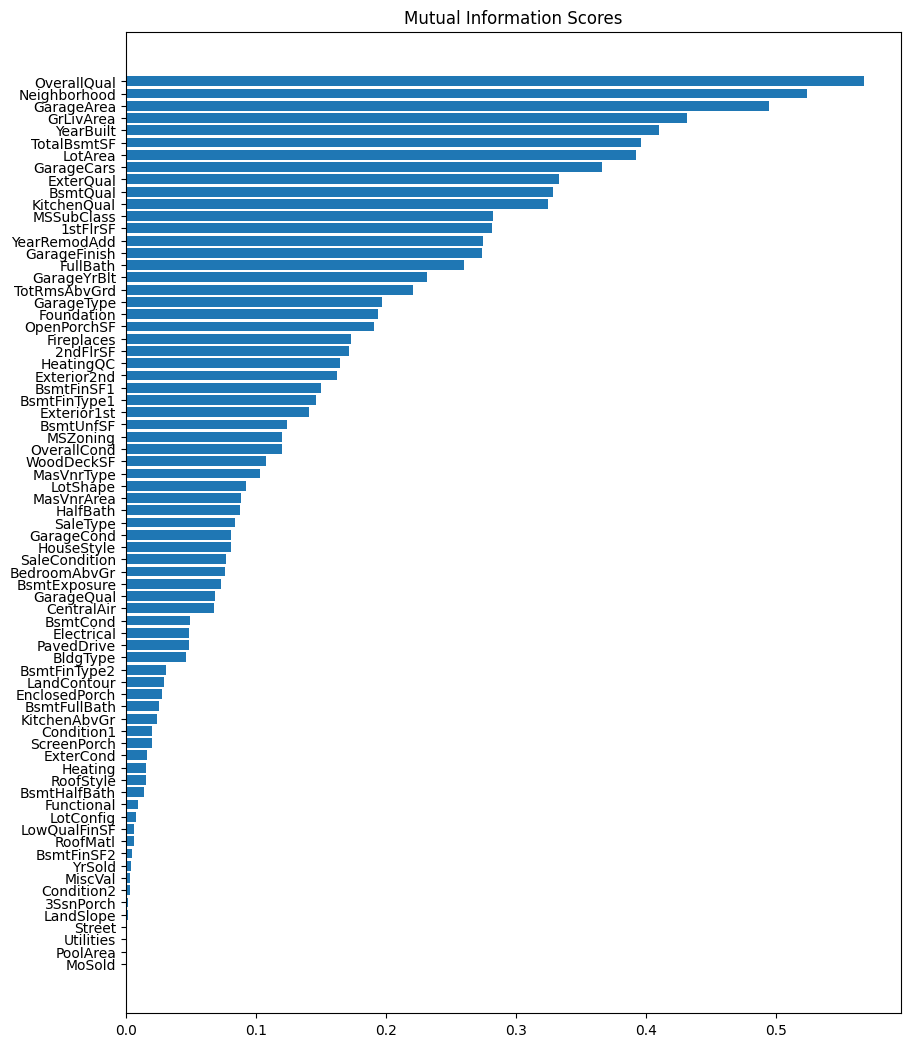

In [104]:
plt.figure(dpi=100, figsize=(10, 13))
plot_mi_score(mi_scores)

##### Remove columns with zero MI Score

In [105]:
data = data.drop(['YrSold', 'MoSold', 'PoolArea',
                 'Utilities', 'Street', 'Condition2',
                 'BsmtFinSF2', '3SsnPorch', 'MiscVal'],
                 axis=1)

In [106]:
x = data.copy()
y = x.pop('SalePrice')

# score
score_dataset(x, y)

0.14137135313135996

When we removed the columns with **MI-Score** zero
The error is get reduced to **0.141371** from **0.144643**

So we going to do same procedure for **Test-Data**

In [107]:
data_test = data_test.drop(['YrSold', 'MoSold', 'PoolArea',
                            'Utilities', 'Street', 'Condition2',
                            'BsmtFinSF2', '3SsnPorch', 'MiscVal'],
                           axis=1)

### 2. Clustering
Clusters will break up complicated relationships across features into simpler chunks

#### Clustering columns with high and Low MI Scores:

Columns with **Low MI-Score** maybe not related with **SalePrice**(Target Column). 
But this maybe related with columns with **High MI Score**
So this is help us to find relationship between these columns.  

Creating a Cluster between **OverallQual** and **LowQualFinSF**

In [108]:
features = ['OverallQual', 'LowQualFinSF']

# Standardize
data_x_scaled = data.loc[:, features]
data_x_scaled = (data_x_scaled - data_x_scaled.mean(axis=0)) / data_x_scaled.std(axis=0)

# create cluster feature
kmeans = KMeans(n_clusters=6, random_state=0)
data['Cluster1'] = kmeans.fit_predict(data_x_scaled)
data['Cluster1'] = data['Cluster1'].astype('category')
data.loc[:, features+['Cluster1']].head()

,OverallQual,LowQualFinSF,Cluster1
Id,,,
1,7,0,0
2,6,0,3
3,7,0,0
4,7,0,0
5,8,0,4


In [109]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.14047073751791622

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.1404707375** from **0.14137135**

Lets try to visualize this clustering.

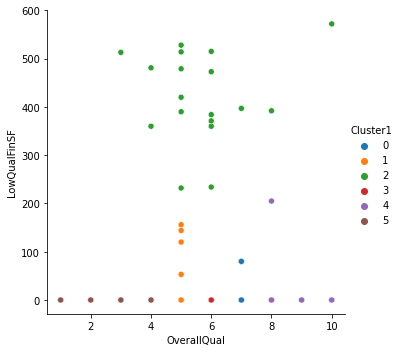

In [110]:
sns.relplot(x='OverallQual', y='LowQualFinSF',
            hue='Cluster1', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster1'>

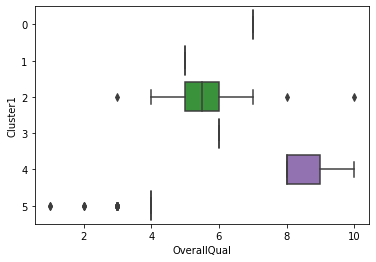

In [111]:
# box plot
sns.boxplot(x='OverallQual', y='Cluster1',
           data=data)

#### Lets write a function for cluster between columns

In [112]:
# Fuction - to create clusters between columns
def cluster_cols(data, col1, col2, n, result_col):
    features = [col1, col2]
    # Standardize
    data_x_scaled = data.loc[:, features]
    data_x_scaled = (data_x_scaled - data_x_scaled.mean(axis=0)) / data_x_scaled.std(axis=0)
    # create cluster feature
    kmeans = KMeans(n_clusters=n, random_state=0)
    data[result_col] = kmeans.fit_predict(data_x_scaled)
    data[result_col] = data[result_col].astype('category')
    return data.loc[:, features+[result_col]].head()

##### Cluster between OverallQual and KitchenAbvGr

In [113]:
cluster_cols(data, 'OverallQual', 'KitchenAbvGr', 8, 'Cluster2')

,OverallQual,KitchenAbvGr,Cluster2
Id,,,
1,7,1,0
2,6,1,3
3,7,1,0
4,7,1,0
5,8,1,4


In [114]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13918334427059587

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.139183344** from **0.1404707375**

Lets try to visualize this clustering.

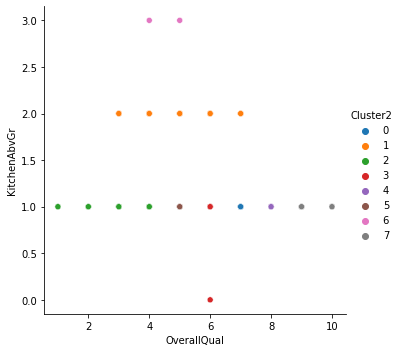

In [116]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='KitchenAbvGr',
           hue='Cluster2', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster2'>

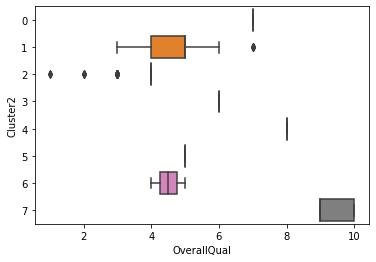

In [117]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster2',
           data=data)

#### Cluster between OverallQual and HalfBath

In [118]:
cluster_cols(data, 'OverallQual', 'HalfBath', 3, 'Cluster3')

,OverallQual,HalfBath,Cluster3
Id,,,
1,7,1,1
2,6,0,0
3,7,1,1
4,7,0,2
5,8,1,1


In [119]:
x = data.copy()
y = x.pop('SalePrice')

# Find the score
score_dataset(x, y)

0.13818376275530941

When we cluster between **High-Low** MI-Score columns.
Error get reduced to **0.13818376** from **0.139183344**

Lets try to visualize this clustering.

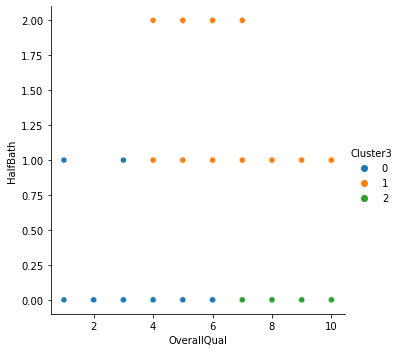

In [120]:
# Visualize this clustering using relational plot
sns.relplot(x='OverallQual', y='HalfBath',
           hue='Cluster3', data=data)

<AxesSubplot:xlabel='OverallQual', ylabel='Cluster3'>

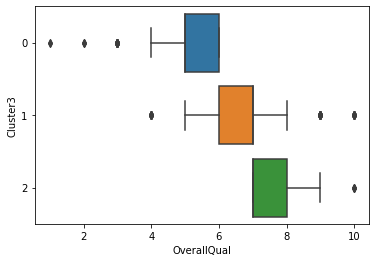

In [121]:
# box-plot
sns.boxplot(x='OverallQual', y='Cluster3',
           data=data)